<a href="https://colab.research.google.com/github/Arvinth-s/Dark-Sight/blob/master/Retinex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#OM NAMO NARAYANA

Implementation of retinex model. Code adapted from: https://github.com/dongb5/Retinex. Just an implementation of https://sci-hub.se/10.1109/83.597272# (July 1997)

In [2]:
import sys
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [3]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
target_dir = '/content/drive/My Drive/Dataset/sampleDataset/0/1/'

In [25]:
def singleScaleRetinex(img, sigma):

    retinex = np.log10(img) - np.log10(cv2.GaussianBlur(img, (0, 0), sigma))

    return retinex

def multiScaleRetinex(img, sigma_list):

    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        retinex += singleScaleRetinex(img, sigma)

    retinex = retinex / len(sigma_list)

    return retinex

def colorRestoration(img, alpha, beta):

    img_sum = np.sum(img, axis=2, keepdims=True)

    color_restoration = beta * (np.log10(alpha * img) - np.log10(img_sum))

    return color_restoration

def simplestColorBalance(img, low_clip, high_clip):    

    total = img.shape[0] * img.shape[1]
    for i in range(img.shape[2]):
        unique, counts = np.unique(img[:, :, i], return_counts=True)
        current = 0
        for u, c in zip(unique, counts):            
            if float(current) / total < low_clip:
                low_val = u
            if float(current) / total < high_clip:
                high_val = u
            current += c
                
        img[:, :, i] = np.maximum(np.minimum(img[:, :, i], high_val), low_val)

    return img    

def MSRCR(img, sigma_list, G, b, alpha, beta, low_clip, high_clip):

    img = np.float64(img) + 1.0

    img_retinex = multiScaleRetinex(img, sigma_list)    
    img_color = colorRestoration(img, alpha, beta)    
    img_msrcr = G * (img_retinex * img_color + b)

    for i in range(img_msrcr.shape[2]):
        img_msrcr[:, :, i] = (img_msrcr[:, :, i] - np.min(img_msrcr[:, :, i])) / \
                             (np.max(img_msrcr[:, :, i]) - np.min(img_msrcr[:, :, i])) * \
                             255
    
    img_msrcr = np.uint8(np.minimum(np.maximum(img_msrcr, 0), 255))
    img_msrcr = simplestColorBalance(img_msrcr, low_clip, high_clip)       

    return img_msrcr

def automatedMSRCR(img, sigma_list):

    img = np.float64(img) + 1.0

    img_retinex = multiScaleRetinex(img, sigma_list)

    for i in range(img_retinex.shape[2]):
        unique, count = np.unique(np.int32(img_retinex[:, :, i] * 100), return_counts=True)
        for u, c in zip(unique, count):
            if u == 0:
                zero_count = c
                break
            else:
                zero_count = 0
            
        low_val = unique[0] / 100.0
        high_val = unique[-1] / 100.0
        for u, c in zip(unique, count):
            if u < 0 and c < zero_count * 0.1:
                low_val = u / 100.0
            if u > 0 and c < zero_count * 0.1:
                high_val = u / 100.0
                break
            
        img_retinex[:, :, i] = np.maximum(np.minimum(img_retinex[:, :, i], high_val), low_val)
        
        img_retinex[:, :, i] = (img_retinex[:, :, i] - np.min(img_retinex[:, :, i])) / \
                               (np.max(img_retinex[:, :, i]) - np.min(img_retinex[:, :, i])) \
                               * 255

    img_retinex = np.uint8(img_retinex)
        
    return img_retinex

def MSRCP(img, sigma_list, low_clip, high_clip):

    img = np.float64(img) + 1.0

    intensity = np.sum(img, axis=2) / img.shape[2]    

    retinex = multiScaleRetinex(intensity, sigma_list)

    intensity = np.expand_dims(intensity, 2)
    retinex = np.expand_dims(retinex, 2)

    intensity1 = simplestColorBalance(retinex, low_clip, high_clip)

    intensity1 = (intensity1 - np.min(intensity1)) / \
                 (np.max(intensity1) - np.min(intensity1)) * \
                 255.0 + 1.0

    img_msrcp = np.zeros_like(img)
    
    for y in range(img_msrcp.shape[0]):
        for x in range(img_msrcp.shape[1]):
            B = np.max(img[y, x])
            A = np.minimum(256.0 / B, intensity1[y, x, 0] / intensity[y, x, 0])
            img_msrcp[y, x, 0] = A * img[y, x, 0]
            img_msrcp[y, x, 1] = A * img[y, x, 1]
            img_msrcp[y, x, 2] = A * img[y, x, 2]

    img_msrcp = np.uint8(img_msrcp - 1.0)

    return img_msrcp

In [26]:
config = {
    "sigma_list": [15, 80, 250],
    "G"         : 5.0,
    "b"         : 25.0,
    "alpha"     : 125.0,
    "beta"      : 46.0,
    "low_clip"  : 0.01,
    "high_clip" : 0.99
}

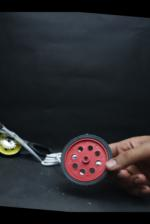

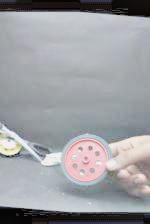

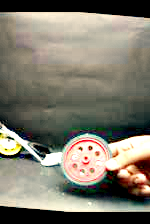

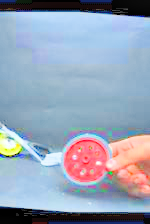

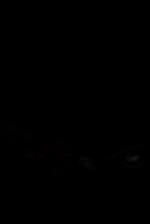

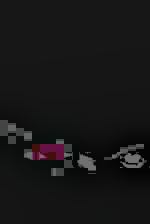

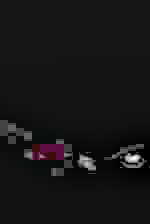

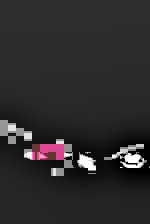

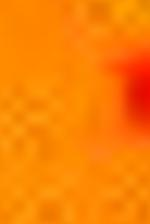

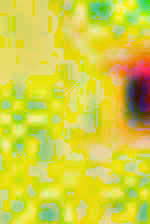

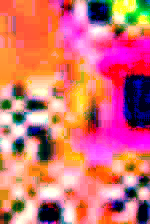

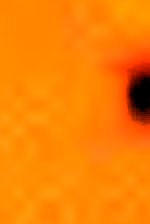

In [27]:
img_list = os.listdir(target_dir)
if len(img_list) == 0:
    print ('Data directory is empty.')
    exit()

if len(img_list) == 0:
    print ('Data directory is empty.')
    exit()

config = {
    "sigma_list": [15, 80, 250],
    "G"         : 5.0,
    "b"         : 25.0,
    "alpha"     : 125.0,
    "beta"      : 46.0,
    "low_clip"  : 0.01,
    "high_clip" : 0.99
}

for img_name in img_list:
    if img_name == '.gitkeep':
        continue
    
    img = cv2.imread(os.path.join(target_dir, img_name))

    img_msrcr = MSRCR(
        img,
        config['sigma_list'],
        config['G'],
        config['b'],
        config['alpha'],
        config['beta'],
        config['low_clip'],
        config['high_clip']
    )
   
    img_amsrcr = automatedMSRCR(
        img,
        config['sigma_list']
    )

    img_msrcp = MSRCP(
        img,
        config['sigma_list'],
        config['low_clip'],
        config['high_clip']        
    )    

    shape = img.shape
    cv2_imshow(img)
    cv2_imshow(img_msrcr)
    cv2_imshow(img_amsrcr)
    cv2_imshow(img_msrcp)
    cv2.waitKey()

Doesn't seem to work well.